In [1]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm 
import numpy as np
#from skimage.transform import resize
from numpy.fft import fftn, fftshift

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
#from sklearn.utils import shuffle
#from sklearn.model_selection import train_test_split


In [2]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20

In [52]:
EPOCHS = 200
NGPUS = torch.cuda.device_count()
BATCH_SIZE = max(NGPUS,1) * 32
LR = NGPUS * 1e-3
print("GPUs:", NGPUS, "Batch size:", BATCH_SIZE, "Learning rate:", LR)

GPUs: 1 Batch size: 32 Learning rate: 0.001


### Generate clean and noisy data from a sin()

Text(0.5, 1.0, 'Training data')

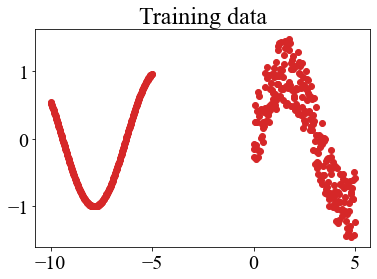

In [40]:
x_train = torch.cat([torch.linspace(-10,-5,250), torch.linspace(0,5,250)]) #Create tensor here and you're good
y_train  = torch.sin(x_train)
noise = np.concatenate([np.zeros(250),np.random.random(x_train[250:].shape)-0.5])
y_train += noise
plt.plot(x_train,y_train,'C3o')
plt.title("Training data")

Text(0.5, 1.0, 'Test data')

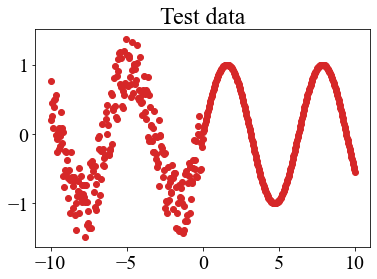

In [60]:
x_test = torch.linspace(-10,10,500) #Create tensor here and you're good
y_test  = torch.sin(x_test)
noise = np.concatenate([np.random.random(x_test[250:].shape)-0.5,np.zeros(250)])
y_test += noise
plt.plot(x_test,y_test,'C3o')
plt.title("Test data")

In [61]:
#Create a TensorDataset and batched loader
train_data = TensorDataset(x_train,y_train)
test_data = TensorDataset(x_test)
N_TRAIN = x_train.shape[0]
N_VALID = 100

train_data2, valid_data = torch.utils.data.random_split(train_data,[N_TRAIN-N_VALID,N_VALID])
print("Train, valid and test", len(train_data2),len(valid_data),len(test_data))

#download and load training data
trainloader = DataLoader(train_data2, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

validloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

#same for test
#download and load training data
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

Train, valid and test 400 100 500


In [43]:
class noisy_model(nn.Module):
    def __init__(self):
        super(noisy_model, self).__init__()
        self.D_in = 1 #Input dimension
        self.D_out = 2 #Output dimension -- predict mean and sigma
        self.H = [50,100,150] #Number of neurons in hidden layers

        self.fc = nn.Sequential(
            nn.Linear(self.D_in, self.H[0]), #Input 
            nn.ReLU(),
        #    nn.Dropout(0.25),
            nn.Linear(self.H[0], self.H[1]),
            nn.ReLU(),
        #    nn.Dropout(0.25),
            nn.Linear(self.H[1], self.H[2]),
            nn.ReLU(),
        #    nn.Dropout(0.25),
            nn.Linear(self.H[2],self.D_out)
        )
    def forward(self,x):
        return self.fc(x)

### Print model summary and move to GPU if available

In [44]:
model = noisy_model()
summary(model,(1,1),device="cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 50]             100
              ReLU-2                [-1, 1, 50]               0
            Linear-3               [-1, 1, 100]           5,100
              ReLU-4               [-1, 1, 100]               0
            Linear-5               [-1, 1, 150]          15,150
              ReLU-6               [-1, 1, 150]               0
            Linear-7                 [-1, 1, 2]             302
Total params: 20,652
Trainable params: 20,652
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.08
Estimated Total Size (MB): 0.08
----------------------------------------------------------------


In [45]:
for x,y in trainloader:
    x = x.to(device)
    y = y.to(device)
    y_pred = model(x.unsqueeze(-1))
    print("Trainloader", x.shape,y.shape,y_pred.shape)
    break

for x,y in validloader:
    x = x.to(device)
    y = y.to(device)
    y_pred = model(x.unsqueeze(-1))
    print("Validloader", x.shape,y.shape,y_pred.shape)
    break

Trainloader torch.Size([32]) torch.Size([32]) torch.Size([32, 2])
Validloader torch.Size([32]) torch.Size([32]) torch.Size([32, 2])


In [46]:
#Optimization details
#criterion = nn.L1Loss()
#More robust to predict the log variance (regularizer)
def aleatoric_loss(y_pred, y_true):
    se = (y_true-y_pred[:,0])**2 #First axis are the predicted means
    inv_std = torch.exp(-y_pred[:,1]) #Second axis are the predicted log variance
    mse = torch.mean(inv_std*se) #1/2*exp(-s)*|y-y_pred|**2
    reg = torch.mean(y_pred[:,1]) #1/2*s term
    return 0.5*(mse + reg)

optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [47]:
def train(trainloader, metrics):
    tot_loss = 0.0
    for i , (x, y) in enumerate(trainloader):
        x = x.to(device) #Move data to approp device
        y = y.to(device)

        y_pred = model(x.unsqueeze(-1)) #Forward pass

        loss = aleatoric_loss (y_pred.squeeze(), y) #Compute loss
        tot_loss += loss.detach().item()

        #Zero current grads and do backprop
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        
    #Divide cumulative loss by number of batches-- sli inaccurate because last batch is different size
    metrics['losses'].append([tot_loss/i]) 


def validate(validloader, metrics):
    tot_loss = 0.0
    for j , (x, y) in enumerate(validloader):
        x = x.to(device) #Move data to approp device
        y = y.to(device)

        y_pred = model(x.unsqueeze(-1)) #Forward pass

        loss = aleatoric_loss (y_pred.squeeze(), y) #Compute loss
        tot_loss += loss.detach().item()
        
    metrics['val_losses'].append([tot_loss/j])


In [48]:
metrics = {'losses':[],'val_losses':[]}#, 'lrs':[], 'best_val_loss' : np.inf}
for epoch in range (EPOCHS):
    
  #Set model to train mode
  model.train() 
    
  #Training loop
  train(trainloader,metrics)

    
  #Switch model to eval mode
  model.eval()
    
  #Validation loop
  validate(validloader,metrics)
  
  print('Epoch: %d | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][0], metrics['val_losses'][-1][0]))

Epoch: 0 | Train Loss: 0.14031 | Val Loss: 0.07865
Epoch: 1 | Train Loss: 0.02141 | Val Loss: 0.12075
Epoch: 2 | Train Loss: -0.03595 | Val Loss: -0.13237
Epoch: 3 | Train Loss: -0.08871 | Val Loss: -0.06396
Epoch: 4 | Train Loss: -0.16518 | Val Loss: -0.12061
Epoch: 5 | Train Loss: -0.21047 | Val Loss: -0.22742
Epoch: 6 | Train Loss: -0.24864 | Val Loss: -0.31634
Epoch: 7 | Train Loss: -0.20919 | Val Loss: -0.17911
Epoch: 8 | Train Loss: -0.26821 | Val Loss: -0.36018
Epoch: 9 | Train Loss: -0.29208 | Val Loss: -0.27759
Epoch: 10 | Train Loss: -0.33876 | Val Loss: -0.28816
Epoch: 11 | Train Loss: -0.31003 | Val Loss: -0.36808
Epoch: 12 | Train Loss: -0.32422 | Val Loss: -0.44236
Epoch: 13 | Train Loss: -0.36321 | Val Loss: -0.28820
Epoch: 14 | Train Loss: -0.36598 | Val Loss: -0.48216
Epoch: 15 | Train Loss: -0.38845 | Val Loss: -0.38127
Epoch: 16 | Train Loss: -0.41004 | Val Loss: -0.34913
Epoch: 17 | Train Loss: -0.43964 | Val Loss: -0.46294
Epoch: 18 | Train Loss: -0.42397 | Val Los

Text(0.5, 43.0, 'Epochs')

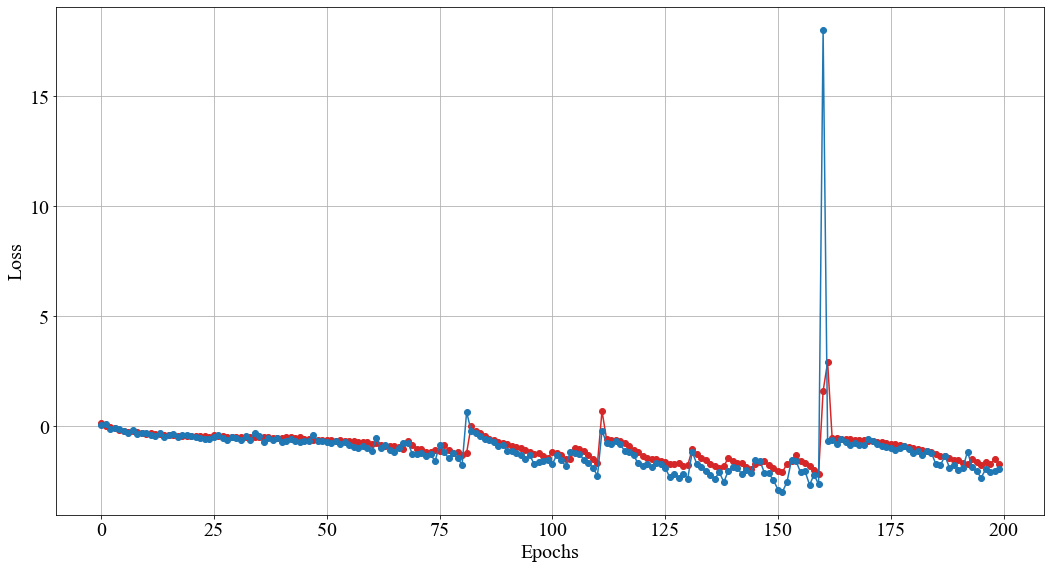

In [49]:
losses_arr = np.array(metrics['losses'])
val_losses_arr = np.array(metrics['val_losses'])
losses_arr.shape
fig, ax = plt.subplots(1,sharex=True, figsize=(15, 8))
ax.plot(losses_arr[:,0], 'C3o-', label = "Total Train loss")
ax.plot(val_losses_arr[:,0], 'C0o-', label = "Total Val loss")
ax.set(ylabel='Loss')
ax.grid()

plt.tight_layout()
plt.xlabel("Epochs")

In [62]:
# Evaluate points with trained model
model.eval()
y_preds = []
for x in testloader:
    x = x[0].to(device)
    evals = model(x.unsqueeze(-1)).squeeze()
    for k in evals:
        y_preds.append(k.detach().to("cpu").numpy())

y_preds = np.array(y_preds)

Text(0.5, 1.0, 'Test data')

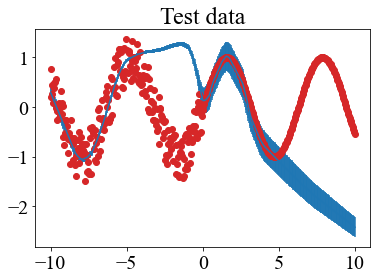

In [63]:
plt.plot(x_test,y_test,'C3o')
aleatoric_std = np.exp(0.5*y_preds[:,1])
plt.errorbar(x_test,y_preds[:,0],yerr=aleatoric_std)
plt.title("Test data")